In [1]:
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)

from tomoSegmentPipeline.losses import Tversky_loss
from tomoSegmentPipeline.utils.common import read_array
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer

PARENT_PATH = setup.PARENT_PATH

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import torch
from torch.utils.data import DataLoader


%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

train_tomos = ['tomo02', 'tomo03', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo10', 'tomo32']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38', 'tomo04']
concat_test_ids = sorted([s.replace('tomo', '') for s in test_tomos])
concat_test_ids = '-'.join(concat_test_ids)

# Get best validation loss models

In [2]:
logs_path = PARENT_PATH + 'data/model_logs/models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, model_file, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass
    
df_model = pd.DataFrame(model_info, columns=['name', 'model_file', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])

print(df_model.shape)
df_model.head()

(18, 9)


,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,386 out of 1000,in84,lr0.000100,v2,0.100280,0.909837
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,238 out of 1000,in84,lr0.000100,v0,0.147336,0.866083
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,355 out of 1000,in84,lr0.000100,v3,0.095781,0.913784
4,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435


In [3]:
bestModel_byType = df_model.loc[df_model.groupby('input_type').best_val_loss_epoch.idxmin()].reset_index(drop=True)
bestModel_byType['batch_size'] = [34, 22, 22, 28]
bestModel_byType

,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice,batch_size
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435,34
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506,22
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,isoNET,472 out of 1000,in84,lr0.000100,v1,0.177506,0.840685,22
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816,28


# Predict full validation tomograms for best models

In [4]:
tomo_file_cryoCARE = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_bin4_denoised_0000.nii.gz'
tomo_file_rawCET = '/home/haicu/jeronimo.carvajal/Thesis/data/raw_cryo-ET/%s.mrc'
tomo_file_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/RAW_dataset/RAW_corrected_i30/%s_corrected.mrc'
tomo_file_cryoCARE_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/%s_bin4_denoised_0000_corrected.mrc'

tomo_input_type_fileDict = {'rawCET':tomo_file_rawCET,
                            'cryoCARE': tomo_file_cryoCARE,
                            'isoNET': tomo_file_isoNET,
                            'cryoCARE+isoNET': tomo_file_cryoCARE_isoNET}

In [5]:
def dice1_alongZ(tomogram_data, labels, pred1):
    
    z, y, x = tomogram_data.shape
    dice1_z = []
    for i in range(z):
        tomogram_z = torch.tensor(tomogram_data[i]).unsqueeze(0).unsqueeze(0).unsqueeze(0)

        labels_z = torch.tensor(labels[i]).unsqueeze(0)
        labels_z = transpose_to_channels_first(to_categorical(labels_z, 3)).unsqueeze(0).to('cuda')

        pred1_z = torch.tensor(pred1[i]).unsqueeze(0)
        pred1_z = transpose_to_channels_first(to_categorical(pred1_z, 2)).unsqueeze(0).to('cuda')

        val = float(Tversky_index(pred1_z, labels_z)[1].cpu().numpy())
        dice1_z.append(val)
        
    return dice1_z

Reading files for cryoCARE...
Calculating dice along Z...
Average Dice1 score along Z:  0.5165366778001671
Adding stuff to plot...

Reading files for cryoCARE+isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.5107465079214809
Adding stuff to plot...

Reading files for isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.4762864155246493
Adding stuff to plot...

Reading files for rawCET...
Calculating dice along Z...
Average Dice1 score along Z:  0.44611339455426285
Adding stuff to plot...



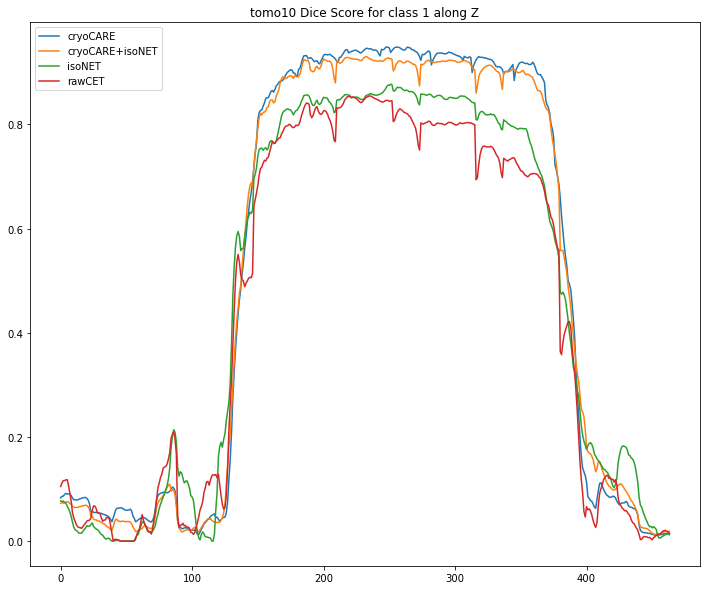

Reading files for cryoCARE...
Calculating dice along Z...
Average Dice1 score along Z:  0.4897716658616477
Adding stuff to plot...

Reading files for cryoCARE+isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.47192334340760334
Adding stuff to plot...

Reading files for isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.452369725121414
Adding stuff to plot...

Reading files for rawCET...
Calculating dice along Z...
Average Dice1 score along Z:  0.4285692757608746
Adding stuff to plot...



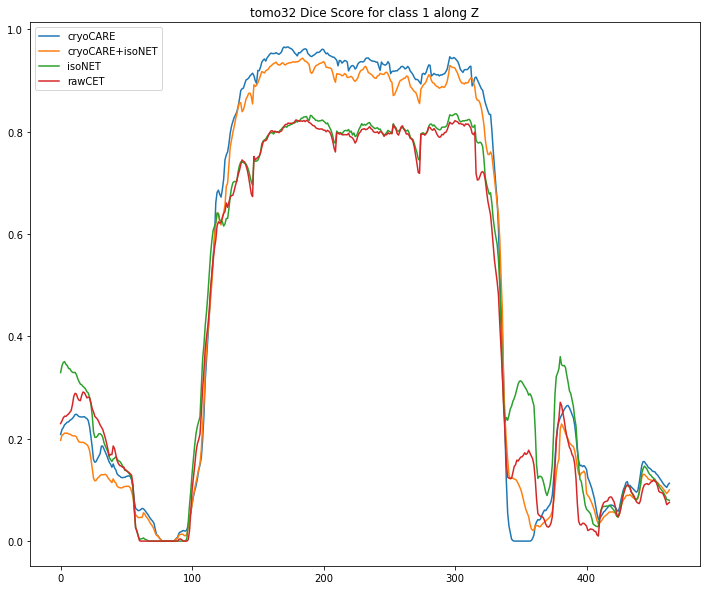

Reading files for cryoCARE...
Calculating dice along Z...
Average Dice1 score along Z:  nan
Adding stuff to plot...

Reading files for cryoCARE+isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  nan
Adding stuff to plot...

Reading files for isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.14438024999078058
Adding stuff to plot...

Reading files for rawCET...
Calculating dice along Z...
Average Dice1 score along Z:  0.14272808678651927
Adding stuff to plot...



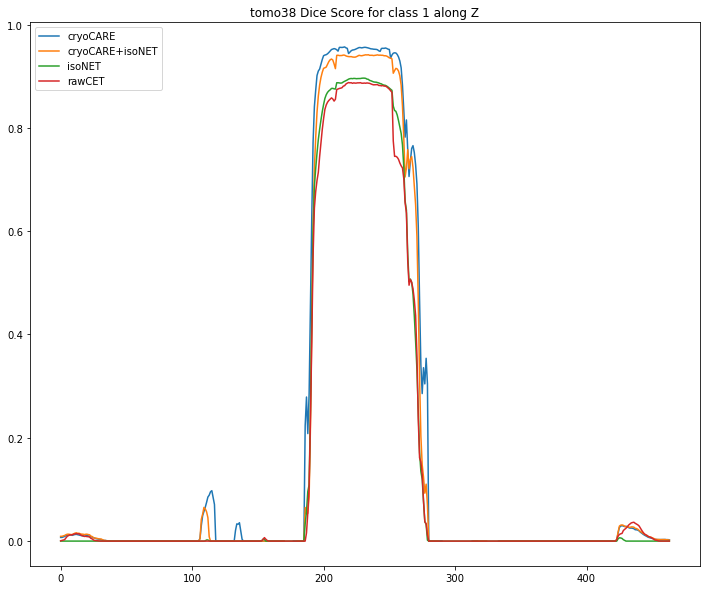

Reading files for cryoCARE...
Calculating dice along Z...
Average Dice1 score along Z:  0.5695617840051925
Adding stuff to plot...

Reading files for cryoCARE+isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.5569500659205695
Adding stuff to plot...

Reading files for isoNET...
Calculating dice along Z...
Average Dice1 score along Z:  0.4859516783279983
Adding stuff to plot...

Reading files for rawCET...
Calculating dice along Z...
Average Dice1 score along Z:  0.46465731779034253
Adding stuff to plot...



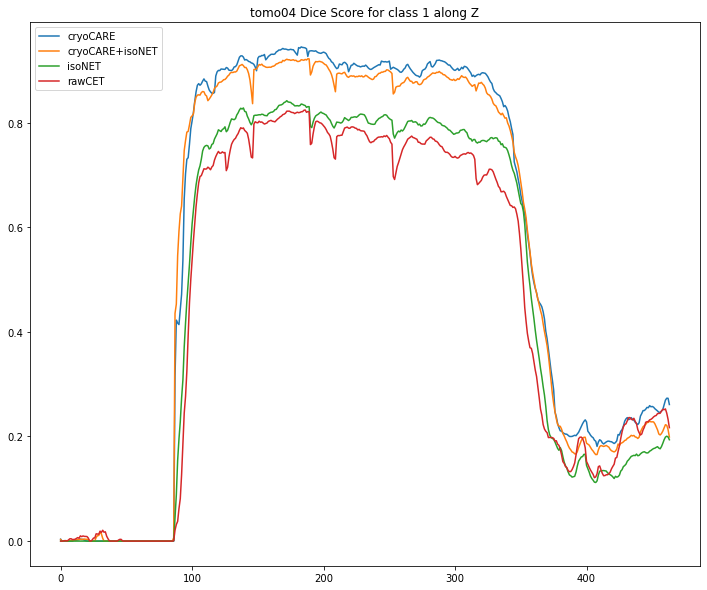

In [6]:
nCenters_dict = {'in56':28, 'in84':14}

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'


for tomo in val_tomos+test_tomos:

    plt.figure(figsize=(12, 10))

    for i, row in bestModel_byType.iterrows():
        model_fileList = [row['model_file']]
        n_centers_list = [nCenters_dict[row['patch_size']]]

        input_type = row['input_type']
        epochs = row['epochs'].split(' ')[-1]
        patch_size = row['patch_size']
        lr = row['lr']
        version = row['version'].replace('v', '')

        pred1_file_aux = f'data/processed1/deepFinder/predictions/{input_type}/Baseline_ep{epochs}_{patch_size}_{lr}_{version}/train02-03-17/'
        pred1_file_aux = PARENT_PATH+pred1_file_aux

        print('Reading files for %s...' %input_type)
        tomo_file = tomo_input_type_fileDict[input_type] %tomo
        label_file = aux_label_file %tomo

        pred1_file = glob(pred1_file_aux+'*%s*'%tomo) # first get all files
        pred1_file = [x for x in pred1_file if 'patch' not in x][0] # then filter out patch predictions

        tomogram_data, labels = load_tomoData(tomo_file, label_file, is_model_data=False)
        pred1 = read_array(pred1_file)

        print('Calculating dice along Z...')
        dice1_z = dice1_alongZ(tomogram_data, labels, pred1)
        
        print('Average Dice1 score along Z: ', np.mean(dice1_z))

        print('Adding stuff to plot...\n')
        plt.plot(dice1_z, label=input_type)

    plt.title('%s Dice Score for class 1 along Z' %tomo)
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
y_truth = transpose_to_channels_first(to_categorical(labels, 3)).unsqueeze(0).to('cuda')
y_pred = transpose_to_channels_first(to_categorical(pred1, 2)).unsqueeze(0).to('cuda')

y_truth.shape